In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
properties = {
    "vgg16": {
        "img_size": (224, 224),
        "last_conv_layer": "block5_conv3",
        "last_classifier_layers": [
            "block5_pool",
            "flatten",
            "fc1",
            "fc2",
            "predictions",
        ],
        "model_builder": keras.applications.vgg16.VGG16,
        "preprocess_input": keras.applications.vgg16.preprocess_input,
        "decode_predictions": keras.applications.vgg16.decode_predictions,
    },
    "xception": {
        "img_size": (299, 299),
        "last_conv_layer": "block14_sepconv2_act",
        "last_classifier_layers": [
            "avg_pool",
            "predictions",
        ],
        "model_builder": keras.applications.xception.Xception,
        "preprocess_input": keras.applications.xception.preprocess_input,
        "decode_predictions": keras.applications.xception.decode_predictions,
        
    }
}

In [3]:
NETWORK = "xception"
IMG_PATH = "newyork_2.jpg"
IMG_SIZE = properties[NETWORK]["img_size"]
LAST_CONV_LAYER = properties[NETWORK]["last_conv_layer"]
CLASSIFIER_LAYER_NAMES = properties[NETWORK]["last_classifier_layers"]

top_n = 2

In [4]:
model_builder = properties[NETWORK]["model_builder"]
preprocess_input = properties[NETWORK]["preprocess_input"]
decode_predictions = properties[NETWORK]["decode_predictions"]

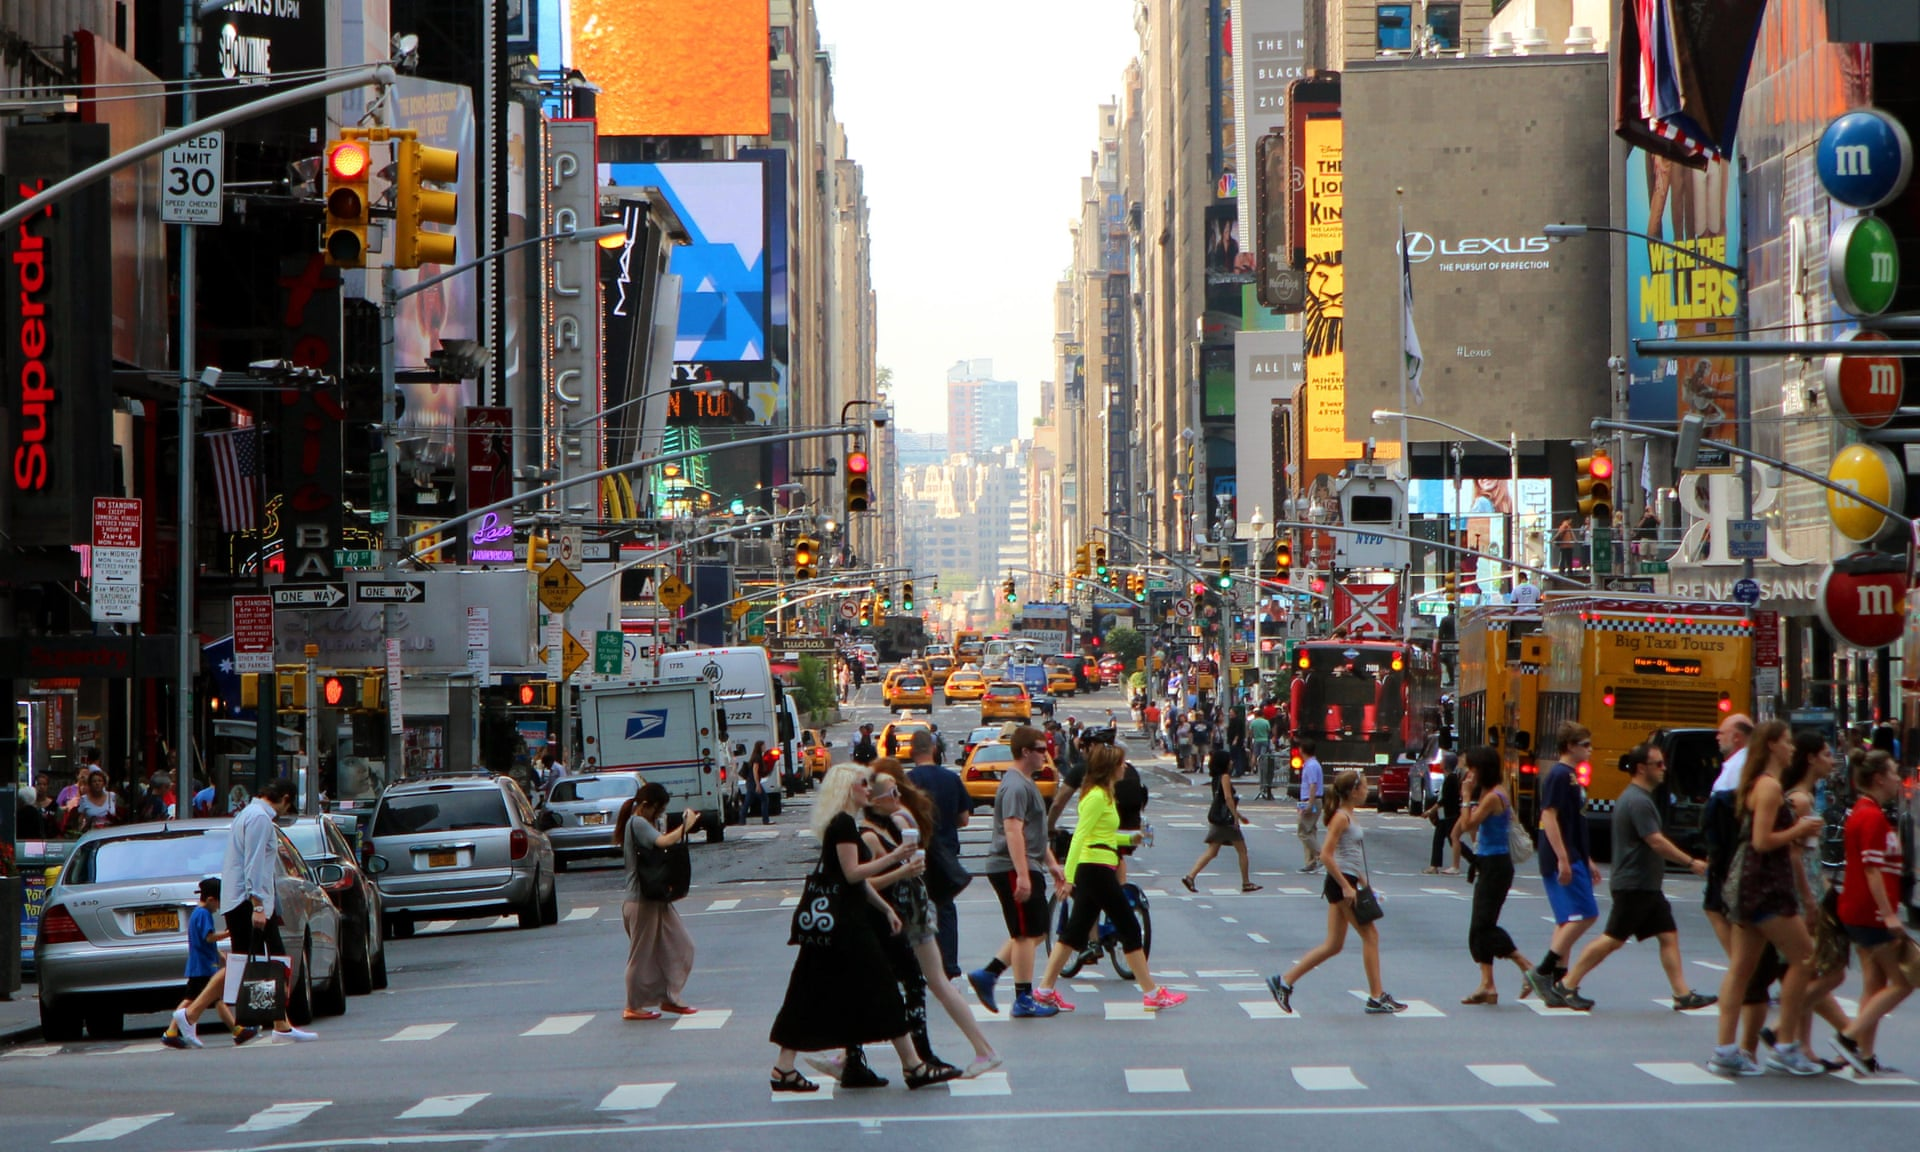

In [5]:
last_conv_layer_name = LAST_CONV_LAYER
classifier_layer_names = CLASSIFIER_LAYER_NAMES
image_size = IMG_SIZE
# img_path = keras.utils.get_file("cat_dog.png", "./cat_dog.png")
display(Image(IMG_PATH))

In [6]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def superimpose_heatmap(image_path, heatmap):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = keras.preprocessing.image.array_to_img(heatmap)
    heatmap = heatmap.resize((img.shape[1], img.shape[0]))
    
    heatmap = keras.preprocessing.image.img_to_array(heatmap)
    superimposed_img = cv2.addWeighted(heatmap, 0.4, img, 0.6, 0)
    
    return superimposed_img

def get_top_predicted_indices(predictions, top_n):
    df = pd.DataFrame({"score": preds.squeeze()})
    df = df.sort_values(by="score", ascending=False)
    return df.head(top_n).index

In [ ]:
img_array = get_img_array(IMG_PATH, size=image_size)
print(img_array.shape)
img_array = preprocess_input(img_array)
model = model_builder(weights="imagenet")
print(1)
preds = model.predict(img_array)
print(2)
preds_n = decode_predictions(preds, top=top_n)
print(f"Predicted:\n {preds_n[0]}")

(1, 299, 299, 3)
1


In [ ]:
def make_gradcam_heatmap(
    img_array, model, 
    last_conv_layer_name, 
    classifier_layer_names,
    top_n
):
    print(1)
    # Create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    print(2)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    print("Before Activations")
    
    # Create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    print("Before Preds")
    
    last_conv_layer_output = last_conv_layer_model(img_array)
    preds = classifier_model(last_conv_layer_output)
    top_n_indices = get_top_predicted_indices(preds, top_n)
    
    print("Before For Loop")
    
    heatmaps = []
    for index in np.arange(top_n):
    
        # Compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            # Compute activations of the last conv layer and make the tape watch it
            last_conv_layer_output = last_conv_layer_model(img_array)
            tape.watch(last_conv_layer_output)

            # Compute class predictions
            preds = classifier_model(last_conv_layer_output)
            class_channel = preds[:, top_n_indices[index]]
            
        grads = tape.gradient(
            class_channel,
            last_conv_layer_output
        )
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))    
        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        
        

        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:, :, i] *= pooled_grads[i]

        # The channel-wise mean of the resulting feature map
        # is our heatmap of class activation
        heatmap = np.mean(last_conv_layer_output, axis=-1)

        # For visualization, normalize the heatmap between [0, 1]
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

        heatmaps.append({
            "class_id": top_n_indices[index],
            "heatmap": heatmap
        })

    return heatmaps

In [ ]:
heatmaps = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names, top_n
)

#heatmap = classwise_gradcam(tape, preds, last_conv_layer_output, 0)

In [ ]:
for index in np.arange(top_n):
    heatmap = heatmaps[index]["heatmap"]
    class_id = heatmaps[index]["class_id"]
    print(class_id, preds_n[0][index])
    superimposed_image = superimpose_heatmap(IMG_PATH, heatmap)
    save_path = "superimposed_image.jpg"
    cv2.imwrite(save_path, superimposed_image)
    display(Image(save_path))

In [ ]:
superimposed_image = superimpose_heatmap(IMG_PATH, heatmap_orig)

In [ ]:
save_path = "superimposed_image.jpg"
cv2.imwrite(save_path, superimposed_image)
display(Image(save_path))